In [1]:

import os
import cv2
import copy
import time
import random
import pickle

import numpy as np
import pandas as pd
from PIL import Image
import seaborn as sns
from pathlib import Path
from tqdm import tqdm

from sklearn.metrics import f1_score, confusion_matrix
from numpy.random import shuffle
import matplotlib.pyplot as plt

import torch
import torchvision
from torchvision.io import read_image
import torchvision.transforms as T
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
import torch.autograd.profiler as tprofiler
import torch.utils.data as td

plt.rcParams["savefig.bbox"] = 'tight'

In [2]:

seed = 42

random.seed(seed)

# pytorch RNGs
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)

# numpy RNG

In [3]:
import sys
sys.path.append('../src/')

In [4]:
%load_ext autoreload
%autoreload 2

from multilabel.train import train_model
from model import initialize_model
from utils import set_requires_grad, save_model
from multilabel.data import load_data
from plotting import plot_data_loader
from multilabel.eval import eval_model

In [5]:
# Check if GPU is available.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# Models options: resnet50, resnet34, inceptionv3, vgg16, mobile_net_v3_large, efficient_net_b1, efficient_net_b0, efficient_net_b3.
model_name = "efficient_net_b3"

# Number of classes.
num_classes = 20

# Batch Size.
batch_size = 32

# Epochs to train for.
num_epochs = 10

# Number of workers for data loader.
num_workers = 12

# Imagenet norm array passed as default value.
# norm_arr=([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
# Chest x-ray8 training dataset metrics 
norm_arr=((0.5989, 0.5510, 0.5175), (0.3358, 0.3330, 0.3377))

# Feature extract flag: False - Tune the whole model,
#                       True - Update only the reshaped layer parameters.
feature_extract = True

# Use pretrained flag: None - Use random weights
#                      String - Use pretrained weights given by String
use_pretrained = models.EfficientNet_B3_Weights.IMAGENET1K_V1

# Initialize the model for this run.
model_pyt, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=use_pretrained)

# lr start and end points for training.
lr_start = 0.01
lr_end = 0.001

# Print the model we just instantiated
#print(model_ft)

# Positive class weights.
pos_weight=torch.as_tensor([ 2.3509,  6.4782, 76.3264, 23.6350, 46.7897, 18.5694, 14.4224, 24.4805,
         1.1795,  0.6394,  9.1227, 80.2774,  0.8743,  2.1217,  7.2973, 87.3730,
        12.8151, 23.7444, 28.1492, 29.6749], dtype=torch.float)
pos_weight = pos_weight.to(device)

cuda:0


In [6]:
images_dir = "../data/processed"
data_loaders = load_data(images_dir,
                         batch_size = batch_size, 
                         input_size = input_size, 
                         norm_arr = norm_arr,
                         num_workers = num_workers)

In [7]:
class_names = data_loaders['train'].dataset.classes

## Efficient Net B3

In [8]:
model_pyt = model_pyt.to(device)
# load saved model directly
model_pyt.load_state_dict(torch.load('../models/efficient_net_b3_ads_10_32_0.01_0.001_model_weights.pth', map_location=device)) 

<All keys matched successfully>

In [9]:
model_pyt.features

Sequential(
  (0): Conv2dNormActivation(
    (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU(inplace=True)
  )
  (1): Sequential(
    (0): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
          (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(40, 24, kernel_size=(1, 1), stride=(1, 1)

In [16]:
model_pyt.features[-3][1]

MBConv(
  (block): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(232, 1392, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(1392, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Conv2dNormActivation(
      (0): Conv2d(1392, 1392, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), groups=1392, bias=False)
      (1): BatchNorm2d(1392, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (2): SqueezeExcitation(
      (avgpool): AdaptiveAvgPool2d(output_size=1)
      (fc1): Conv2d(1392, 58, kernel_size=(1, 1), stride=(1, 1))
      (fc2): Conv2d(58, 1392, kernel_size=(1, 1), stride=(1, 1))
      (activation): SiLU(inplace=True)
      (scale_activation): Sigmoid()
    )
    (3): Conv2dNormActivation(
      (0): Conv2d(1392, 232, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(232, eps=1e-05, momentum=0.1, affine=True, track

In [14]:
def normalise(tens):
    temp = tens.detach().cpu().numpy()
    return (255*(temp - np.min(temp))/np.ptp(temp)).astype(int)   

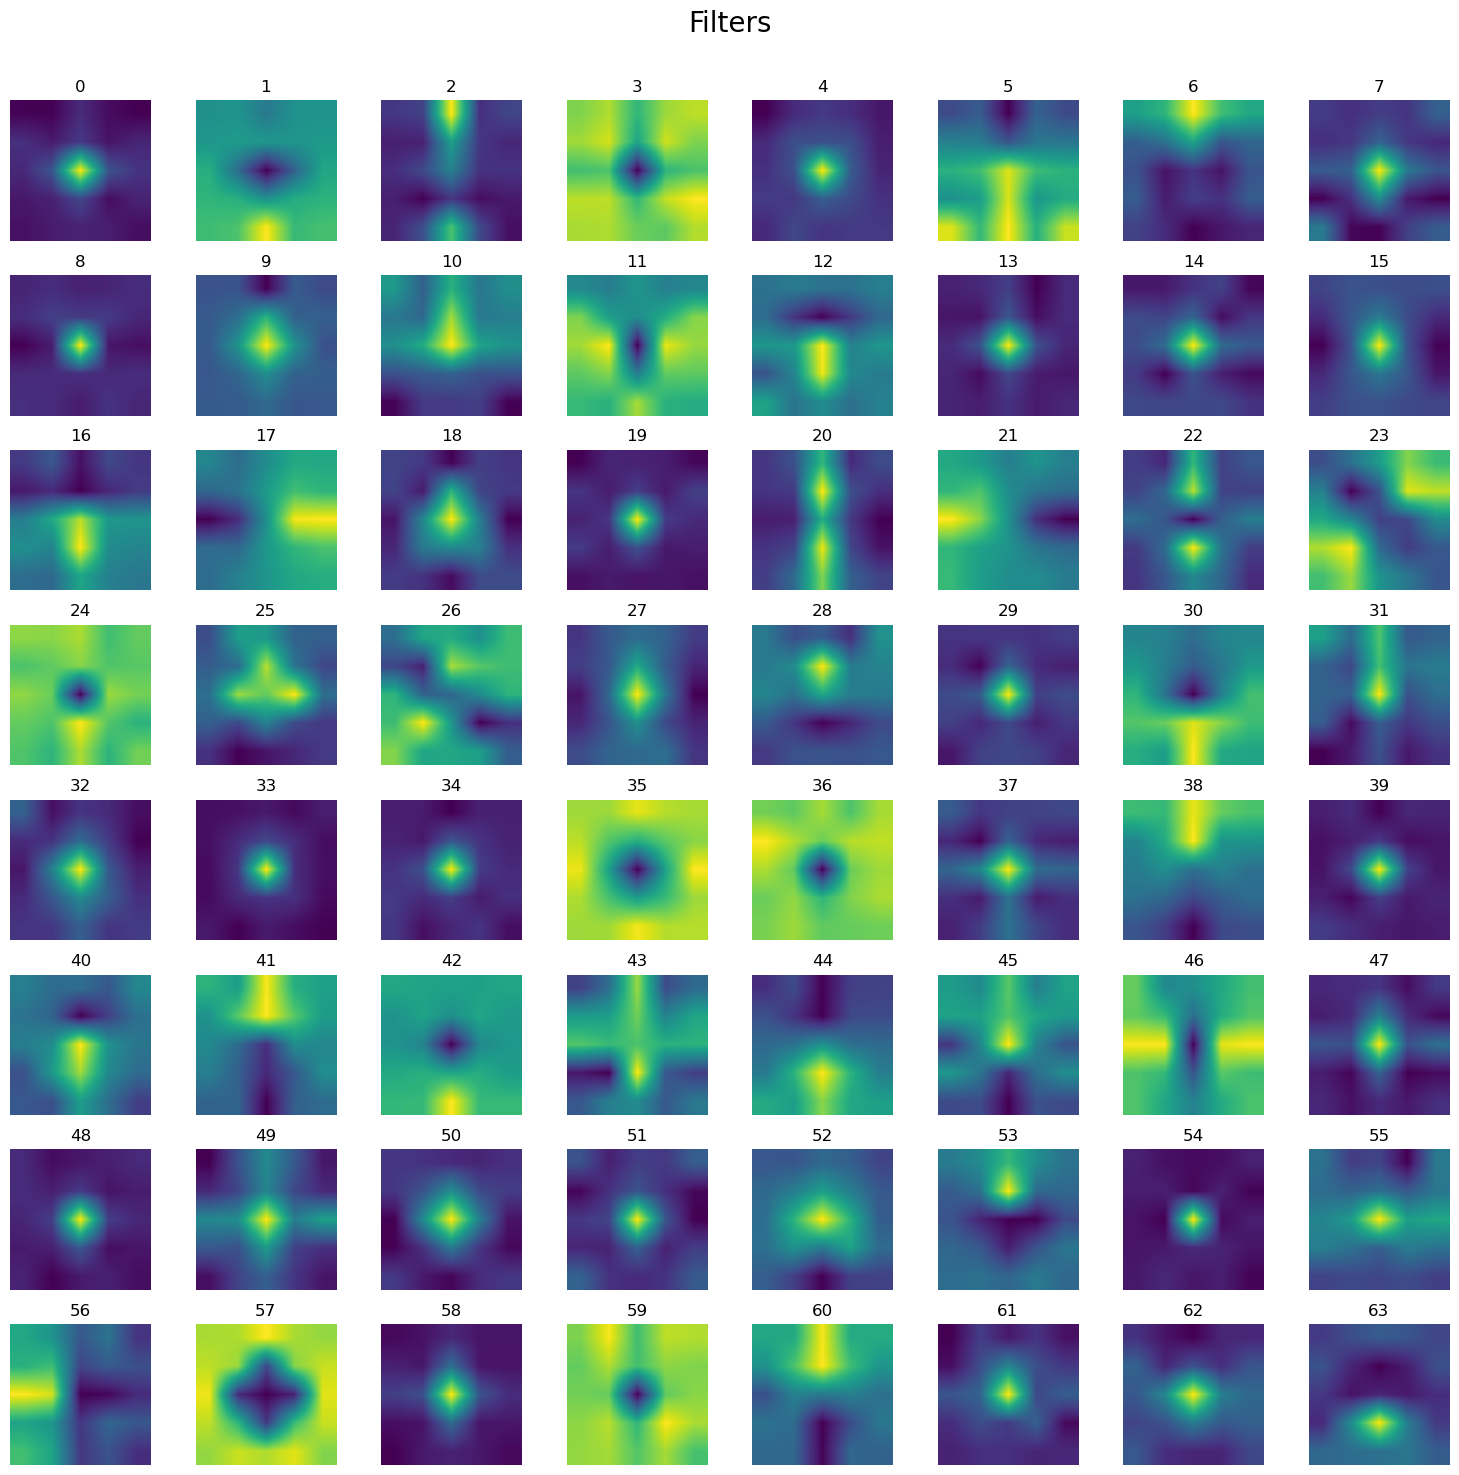

In [28]:
weights = model_pyt.features[-3][1].block[1][0].weight
weights.shape
fig,axes = plt.subplots(8, 8, figsize=(15,15))
for i in range(64):
    axes.ravel()[i].axis('off')
    axes.ravel()[i].imshow(normalise(weights[i].permute(1,2,0)), interpolation = 'bilinear')
    axes.ravel()[i].set_title(i)
fig.suptitle('Filters', fontsize = 20)
fig.tight_layout()
fig.subplots_adjust(top=0.92)
plt.show()

In [29]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model.eval()
        self.featuremaps = []
        self.gradients = []

        target_layer.register_forward_hook(self.save_featuremaps)
        target_layer.register_backward_hook(self.save_gradients)

    def save_featuremaps(self, module, input, output):
        self.featuremaps.append(output)

    def save_gradients(self, module, grad_input, grad_output):
        self.gradients.append(grad_output[0])

    def get_cam_weights(self, grads):
        return np.mean(grads, axis=(1, 2))

    def __call__(self, image, label=None):
        preds = self.model(image)
        self.model.zero_grad()
        
        if label is None:
            label = preds.argmax(dim=1).item()
        
       
        preds[:, label].backward()

        featuremaps = self.featuremaps[-1].cpu().data.numpy()[0, :]
        gradients = self.gradients[-1].cpu().data.numpy()[0, :]

        weights = self.get_cam_weights(gradients)
        cam = np.zeros(featuremaps.shape[1:], dtype=np.float32)

        for i, w in enumerate(weights):
            cam += w * featuremaps[i]

        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, image.shape[-2:][::-1])
        cam = cam - np.min(cam)
        cam = cam / np.max(cam)
        return label, cam

In [30]:
def deprocess_image(image):
    image = image.cpu().numpy()
    image = np.squeeze(np.transpose(image[0], (1, 2, 0)))

    image = image * np.array((0.5989, 0.5510, 0.5175)) + \
        np.array((0.3358, 0.3330, 0.3377))  
    image = image.clip(0, 1)
    return image


def plot_confmat(train_mat, test_mat, classes, filename):
    train_mat = pd.DataFrame(train_mat.numpy(), index=classes, columns=classes)
    test_mat = pd.DataFrame(test_mat.numpy(), index=classes, columns=classes)

    #plt.style.use('seaborn-whitegrid')
    fig = plt.figure(figsize=(8, 4))

    ax = fig.add_subplot(121)
    ax = sns.heatmap(train_mat, annot=True, cmap='tab20c',
                     fmt='d', annot_kws={'size': 18})
    ax.set_title('Confusion Matrix (Train Set)', fontweight='bold')
    ax.set_xlabel('Predicted Classes', fontweight='bold')
    ax.set_ylabel('Actual Classes', fontweight='bold')

    ax = fig.add_subplot(122)
    ax = sns.heatmap(test_mat, annot=True, cmap='tab20c',
                     fmt='d', annot_kws={'size': 18})
    ax.set_title('Confusion Matrix (Test Set)', fontweight='bold')
    ax.set_xlabel('Predicted Classes', fontweight='bold')
    ax.set_ylabel('Actual Classes', fontweight='bold')

    fig.savefig(f'outputs/confusion_matrices/{filename}')
    plt.show()
    plt.close()


def apply_mask(image, mask):
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(image)
    cam = cam / np.max(cam)
    return np.uint8(255 * cam)

In [31]:
image, label = next(iter(data_loaders['test']))

In [32]:
from pytorch_grad_cam import GradCAM as GC
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

In [77]:
class Hook():
    def __init__(self, m):
        self.hook = m.register_forward_hook(self.hook_func)   
    def hook_func(self, m, i, o): self.stored = o.detach().clone()
    def __enter__(self, *args): return self
    def __exit__(self, *args): self.hook.remove()
        

class HookBwd():
    def __init__(self, m):
        self.stored = None
        self.hook = m.register_backward_hook(self.hook_func)   
    def hook_func(self, m, gi, go): self.stored = go[0].detach().clone()
    def __enter__(self, *args): return self
    def __exit__(self, *args): self.hook.remove()

In [40]:
image1 = image[0].to(device)
label1 = label[0].to(device)
image1 = image1.view(1, 3, 320, 320)

preds = model_pyt(image1)

In [41]:
class_names[torch.argmax(preds).cpu()]

'Inspired'

In [36]:
model_pyt[0]

TypeError: 'EfficientNet' object is not subscriptable

In [46]:
model_pyt.features[-1]

Conv2dNormActivation(
  (0): Conv2d(384, 1536, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (1): BatchNorm2d(1536, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): SiLU(inplace=True)
)

In [47]:
model_pyt.features[0]

Conv2dNormActivation(
  (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): SiLU(inplace=True)
)

In [73]:
h = HookBwd(model_pyt.features[0])

In [76]:
dir(h)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__enter__',
 '__eq__',
 '__exit__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'hook',
 'hook_func']

In [78]:
grads = []
for cls in range(20):
    with HookBwd(model_pyt.features[0]) as hookb:
        with Hook(model_pyt.features[0]) as hookf:
            output = model_pyt.eval()(image1)
            act = hookf.stored
        output[0, cls].backward()
        grads.append(hookb.stored)

In [79]:
grads

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [43]:
cam_maps = []
for i in range(11):
    w = grads[i][0].mean(dim=[1,2], keepdim = True)
    cam_maps.append(F.relu((w*act[0]).sum(0)))

TypeError: 'NoneType' object is not subscriptable

In [29]:
#import warnings
#warnings.filterwarnings("ignore")

for i in range(len(image)):

  image1 = image[i].to(device)
  label1 = label[i].to(device)

  #sample_fname, _ = data_loaders['test'].dataset.samples[i]
  image1 = image1.view(1, 3, 320, 320)


  cam_obj = GradCAM(model=model_pyt, target_layer=model_pyt.features[-1]) 
  _, efficient_cam = cam_obj(image1, label1)

  image1 = deprocess_image(image1)
  eff_img = apply_mask(image1, efficient_cam)[:, :, ::-1]

  fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,6))

  plt.setp((ax1,ax2), xticks=[],yticks=[])

  ax1.imshow(image1)
  ax1.set_xlabel(str(class_names[label1.item()]) +" (original)")
  ax1.set_title("Class:"+str(class_names[label1.item()]))
  ax2.imshow(eff_img)
  ax2.set_xlabel("EFFICIENTNET")

  plt.subplots_adjust(wspace=0.00, hspace=0.00)

IndexError: tensors used as indices must be long, byte or bool tensors

In [30]:
label1

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.], device='cuda:0')